<a href="https://colab.research.google.com/github/Ruijia0/SupplyChain_Analytics/blob/main/CaLNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [ ]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [ ]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [ ]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [ ]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [ ]:
def determine_actual_usage(demand_data, calng_price, peak_intake, total_lng):
    # Assuming demand_data has a 'Demand' column with daily demand values
    daily_demand = demand_data['Demand']

    # Calculate the total demand for the season (sum of daily demands)
    total_demand = daily_demand.sum()

    # If the total demand exceeds total LNG available, cap the usage at total LNG
    actual_lng_usage = min(total_demand, total_lng)

    # Use pipeline intake as a constraint: If the demand exceeds pipeline intake, use LNG to cover the gap
    actual_pipeline_usage = min(peak_intake * 365, total_demand)

    # LNG usage will cover the remaining demand beyond what the pipeline can supply
    actual_lng_usage = max(0, total_demand - actual_pipeline_usage)

    # Return the calculated usage as a dictionary
    usage_data = {
        "actual_lng_usage": actual_lng_usage,
        "actual_pipeline_usage": actual_pipeline_usage,
        "total_demand": total_demand
    }

    return usage_data


In [ ]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake, total_lng, return_data=False):
    # Example cost calculation
    actual_lng_usage = usage_data['actual_lng_usage']
    actual_pipeline_usage = usage_data['actual_pipeline_usage']

    # Calculate the total cost based on usage
    # Example cost structure: LNG cost is based on total LNG used, and pipeline cost is based on peak intake
    total_lng_cost = actual_lng_usage * calng_price  # Cost of LNG used
    pipeline_cost = actual_pipeline_usage * 0.5  # Example: Pipeline cost (assumed to be cheaper per unit)

    # Total cost is the sum of LNG and pipeline costs
    total_utility_cost = total_lng_cost + pipeline_cost

    # If you need to return detailed data for further analysis:
    if return_data:
        cost_data = {
            "total_utility_cost": total_utility_cost,
            "total_lng_cost": total_lng_cost,
            "pipeline_cost": pipeline_cost,
            "actual_lng_usage": actual_lng_usage,
            "actual_pipeline_usage": actual_pipeline_usage
        }
        return cost_data
    else:
        # Otherwise just return the total cost
        return total_utility_cost


# demand

Optimal parameters:
Total LNG: 750.0
Peak Pipeline Intake: 175.0
Average Cost: $401.98


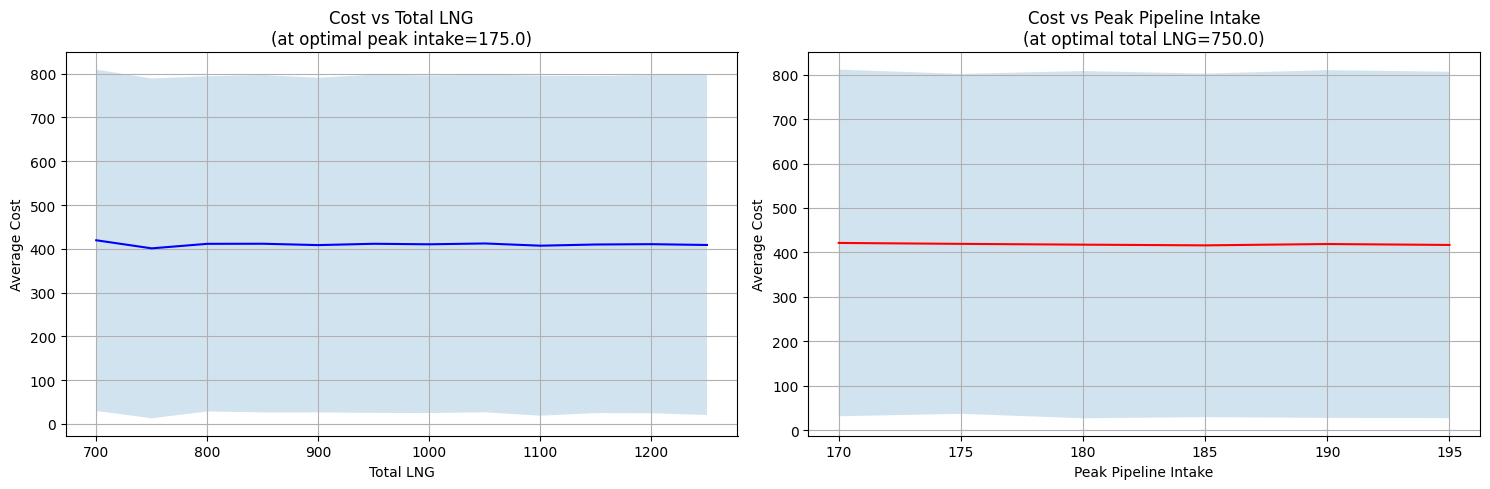

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def simulate_costs_with_std(peak_intake, total_lng, num_samples=5000):
    min_demand = 20
    max_demand = 304
    demands = np.random.uniform(min_demand, max_demand, num_samples)

    costs = []
    for demand in demands:
        pipeline_intake = min(demand, peak_intake)
        pipeline_price = math.exp(max(0, (pipeline_intake - 144)/60))
        pipeline_cost = pipeline_intake * pipeline_price

        if demand > peak_intake and total_lng > 0:
            calng_intake = min(demand - peak_intake, total_lng)
            calng_cost = calng_intake * 7.50
            total_cost = pipeline_cost + calng_cost
        else:
            total_cost = pipeline_cost

        costs.append(total_cost)

    return np.mean(costs), np.std(costs)

# First find optimal values
results = []
for total_lng in range(700, 1300, 50):
    for peak_intake in range(170, 200, 5):
        mean_cost, std_cost = simulate_costs_with_std(peak_intake, total_lng)
        results.append({
            'total_lng': total_lng,
            'peak_intake': peak_intake,
            'avg_cost': mean_cost
        })

results_df = pd.DataFrame(results)
optimal = results_df.loc[results_df['avg_cost'].idxmin()]
optimal_total_lng = optimal['total_lng']
optimal_peak_intake = optimal['peak_intake']

print(f"Optimal parameters:")
print(f"Total LNG: {optimal_total_lng}")
print(f"Peak Pipeline Intake: {optimal_peak_intake}")
print(f"Average Cost: ${optimal['avg_cost']:.2f}")

# Generate plots
lng_costs = []
lng_stds = []
for total_lng in range(700, 1300, 50):
    mean_cost, std_cost = simulate_costs_with_std(optimal_peak_intake, total_lng)
    lng_costs.append(mean_cost)
    lng_stds.append(std_cost)

peak_costs = []
peak_stds = []
for peak_intake in range(170, 200, 5):
    mean_cost, std_cost = simulate_costs_with_std(peak_intake, optimal_total_lng)
    peak_costs.append(mean_cost)
    peak_stds.append(std_cost)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

x1 = list(range(700, 1300, 50))
ax1.plot(x1, lng_costs, 'b-', label='Mean Cost')
ax1.fill_between(x1,
                 np.array(lng_costs) - np.array(lng_stds),
                 np.array(lng_costs) + np.array(lng_stds),
                 alpha=0.2)
ax1.set_xlabel('Total LNG')
ax1.set_ylabel('Average Cost')
ax1.set_title(f'Cost vs Total LNG\n(at optimal peak intake={optimal_peak_intake})')
ax1.grid(True)

x2 = list(range(170, 200, 5))
ax2.plot(x2, peak_costs, 'r-', label='Mean Cost')
ax2.fill_between(x2,
                 np.array(peak_costs) - np.array(peak_stds),
                 np.array(peak_costs) + np.array(peak_stds),
                 alpha=0.2)
ax2.set_xlabel('Peak Pipeline Intake')
ax2.set_ylabel('Average Cost')
ax2.set_title(f'Cost vs Peak Pipeline Intake\n(at optimal total LNG={optimal_total_lng})')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [18]:
def simulate_costs_with_std(peak_intake, total_lng, num_samples=5000):
    min_demand = 20
    max_demand = 304
    print(f"Number of draws: {num_samples}")
    demands = np.random.uniform(min_demand, max_demand, num_samples)

    costs = []
    for demand in demands:
        pipeline_intake = min(demand, peak_intake)
        pipeline_price = math.exp(max(0, (pipeline_intake - 144)/60))
        pipeline_cost = pipeline_intake * pipeline_price

        if demand > peak_intake and total_lng > 0:
            calng_intake = min(demand - peak_intake, total_lng)
            calng_cost = calng_intake * 7.50
            total_cost = pipeline_cost + calng_cost
        else:
            total_cost = pipeline_cost

        costs.append(total_cost)

    return np.mean(costs), np.std(costs)

# Test one simulation
mean_cost, std_cost = simulate_costs_with_std(180, 700)

Number of draws: 5000
